## Frequent category imputation

In the previous section we discussed the imputation of missing values in numerical variables. Categorical variables may also contain missing values. The methods of imputation share the same principle as those for numerical values.

Replacement of missing values by the most frequent category is the equivalent of mean/median imputation. It consists of replacing all occurrences of missing values (NA) within a variable by the most frequent label or category of the variable.


### Assumptions

Replacement of NA by the most frequent category has the assumption that the data are missing completely at random (MCAR). The rationale is that the value that should have been seen for the missing observation is most likely the most frequent value or category.

### Advantages

- Easy to implement
- Fast way of obtaining complete datasets

### Limitations

- Distortion the relation of the most frequent label with other variables within the dataset
- May lead to an over-representation of the most frequent label if there is a big number of NA

===============================================================================

## Real Life example: 

### Predicting Sale Price of Houses

The problem at hand aims to predict the final sale price of homes based on different explanatory variables describing aspects of residential homes. Predicting house prices is useful to identify fruitful investments, or to determine whether the price advertised for a house is over or underestimated, before making a buying judgment.

=============================================================================

In the following cells, I will demonstrate NA imputation by most frequent category using the House Price datasets from Kaggle.

If you haven't downloaded the dataset yet, in the lecture "Guide to setting up your computer" in section 1, you can find the details on how to do so.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

# for regression problems
from sklearn.linear_model import LinearRegression, Ridge

# to split and standarize the datasets
from sklearn.model_selection import train_test_split

# to evaluate regression models
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### House Price dataset

In [2]:
# let's load the dataset with a few columns for the demonstration
cols_to_use = ['BsmtQual', 'FireplaceQu', 'GarageType', 'SalePrice']

data = pd.read_csv('houseprice.csv', usecols=cols_to_use)

# let's inspect the percentage of missing values in each variable
data.isnull().mean().sort_values(ascending=True)

SalePrice      0.000000
BsmtQual       0.025342
GarageType     0.055479
FireplaceQu    0.472603
dtype: float64

The variables BsmtQual and GarageType contain only a few observations with NA (2.5 and 5 %, respectively), therefore, replacing those observations with the value of the most frequent category is a good approach. 

On the other hand, the variable FireplaceQu, contains missing data in  almost half of the observations. Therefore, replacing those with the most frequent category is most likely going to distort the relationship of the most frequent category with the sale price. In addition, if so many observations contain missing values, it has to be for a reason, so we would be better off capturing missingness somehow. In future lectures, I will show how to capture missingness in categorical variables.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the most frequent category has to be selected from the training set, and used to replace NA both in train and test sets.

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[['BsmtQual', 'FireplaceQu', 'GarageType']],
                                                    data.SalePrice, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 3), (438, 3))

### Let's inspect the frequency of the labels in the different variables

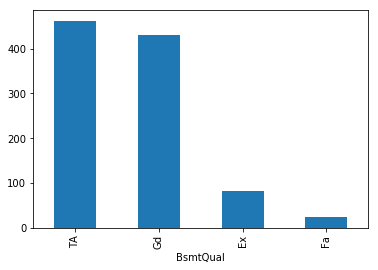

In [4]:
X_train.groupby(['BsmtQual'])['BsmtQual'].count().sort_values(ascending=False).plot.bar()

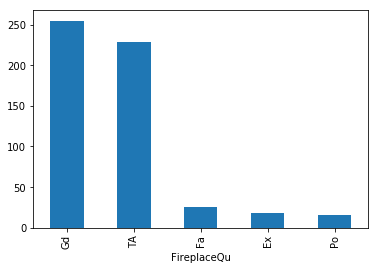

In [5]:
X_train.groupby(['FireplaceQu'])['FireplaceQu'].count().sort_values(ascending=False).plot.bar()

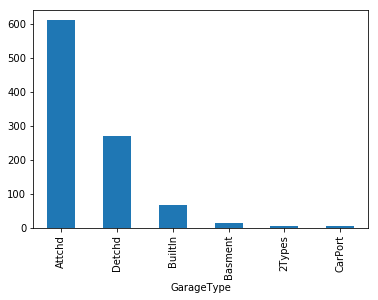

In [6]:
X_train.groupby(['GarageType'])['GarageType'].count().sort_values(ascending=False).plot.bar()

The first 2 variables show 2 predominant categories (first 2 plots). The third variable shows one predominant category. By predominant, I mean category that contains the majority of the observations.

In [7]:
# with this command we capture the most frequent label (check output with plot above)
X_train.groupby(['GarageType'])['GarageType'].count().sort_values(ascending=False).index[0]

'Attchd'

In [8]:
# let's create a variable to replace NA with the most frequent label
# both in train and test set

def impute_na(df_train, df_test, variable):
    most_frequent_category = df_train.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    df_train[variable].fillna(most_frequent_category, inplace=True)
    df_test[variable].fillna(most_frequent_category, inplace=True)

In [9]:
# and let's replace the NA
for variable in ['BsmtQual', 'FireplaceQu', 'GarageType',]:
    impute_na(X_train, X_test, variable)

In [10]:
# let's check that NA have been replaced by inspecting the percentage of null values
X_train.isnull().sum()

BsmtQual       0
FireplaceQu    0
GarageType     0
dtype: int64

In [11]:
X_test.isnull().sum()

BsmtQual       0
FireplaceQu    0
GarageType     0
dtype: int64

In [12]:
# let's transform the categories into numbers quickly and dirty so we can use them in scikit-learn
# the below function numbers the labels from 0 to n, n being the number of different labels 
#  within the variable

for col in ['BsmtQual', 'FireplaceQu', 'GarageType',]:
    labels_dict = {k:i for i, k in enumerate(X_train[col].unique(), 0)}
    X_train.loc[:, col] = X_train.loc[:, col].map(labels_dict )
    X_test.loc[:, col] = X_test.loc[:, col].map(labels_dict)
    
X_train.head()

,BsmtQual,FireplaceQu,GarageType
64,0,0,0
682,0,0,0
960,1,0,0
1384,1,0,1
1100,1,0,1


### Linear Regression

In [13]:
# Let's evaluate the performance of Linear Regression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
print('Train set')
pred = linreg.predict(X_train)
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set')
pred = linreg.predict(X_test)
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()


Train set
Linear Regression mse: 5508120196.474013
Test set
Linear Regression mse: 6364449797.852686



As you can see, imputation by the most frequent category is a straightforward approach to complete datasets to use in machine learning.

### How did these feature pre-processing affect the original variable?

I mentioned previously that the variable FireplaceQu contained a high percentage of missing data. Therefore, very likely, replacing those observations by the most frequent category will affect the distribution of House prices within that label. 

Let's go ahead and have a look at how this imputation method affects variables when the number of missing values is high.

In [14]:
# let's recreate a training set where data are missing for FireplpaceQu

# we do the split again over the original dataset, with the same seed, so that we obtain the same split

X_train, X_test, y_train, y_test = train_test_split(data[['BsmtQual', 'FireplaceQu', 'GarageType', 'SalePrice']],
                                                    data.SalePrice, test_size=0.3,
                                                    random_state=0)

# and now we check the missing values
X_train.isnull().mean()

BsmtQual       0.023483
FireplaceQu    0.467710
GarageType     0.052838
SalePrice      0.000000
dtype: float64

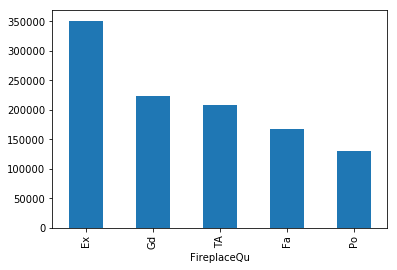

In [15]:
# let's inspect the average house price per category /  label within the variable FireplaceQu

X_train.groupby(['FireplaceQu'])['SalePrice'].mean().sort_values(ascending=False).plot.bar()

And then compare with the average  house price when this variable has missing observations.

In [16]:
X_train[X_train.FireplaceQu.isnull()]['SalePrice'].mean()

140740.83263598327

We can see that the average price for the most frequent category Gd is around 200,000, whereas the average price for houses with missing observations is 140,000.

Let's plot the 2 distributions together for a clearer view of the distribution of prices.

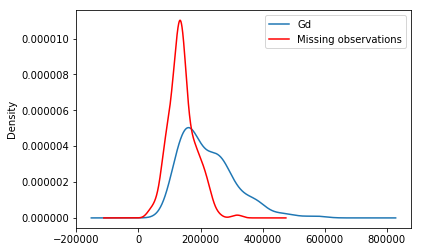

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train[X_train.FireplaceQu=='Gd']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train.FireplaceQu.isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
labels = ['Gd', 'Missing observations']
ax.legend(lines, labels, loc='best')

When values are missing for FirePlace, the average house price is around USS 140k. On the other hand, the average house price for the most frequent label (Gd), is over USS 200k. Thus, we can anticipate that replacing the missing observations by the most frequent label Gd is likely going to take the average of the house price down for that label. And this may affect the performance of the algorithm.

In [18]:
# let's check how many observations we have per category
X_train.FireplaceQu.value_counts()

Gd    255
TA    229
Fa     26
Ex     18
Po     16
Name: FireplaceQu, dtype: int64

In [19]:
# let's create a copy of the dataframe
temp = X_train.copy()

# fill the missing values with 'Ex'
impute_na(X_train, X_test, 'FireplaceQu')

X_train.FireplaceQu.value_counts()

Gd    733
TA    229
Fa     26
Ex     18
Po     16
Name: FireplaceQu, dtype: int64

The imputation by most frequent category takes the number of houses with the label 'Gd' from 255 in the original dataset, to 733! Therefore, this might have a big impact on the distribution of Sale Price for that category. Let's  have a look.

In [20]:
# let's put all the variables within one new dataframe so we can plot them within one plot
temp = pd.concat([temp[['FireplaceQu', 'SalePrice']], X_train.FireplaceQu], axis=1)
temp.columns = ['FireplaceQu', 'SalePrice', 'Fireplace_imputed']
temp.head()

,FireplaceQu,SalePrice,Fireplace_imputed
64,NaN,219500,Gd
682,Gd,173000,Gd
960,NaN,116500,Gd
1384,NaN,105000,Gd
1100,NaN,60000,Gd


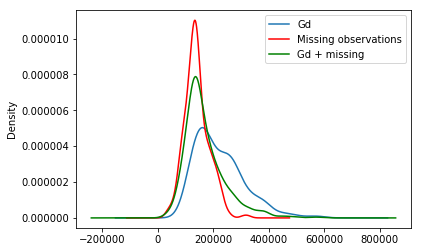

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
temp[temp.FireplaceQu=='Gd']['SalePrice'].plot(kind='kde', ax=ax)
temp[temp.FireplaceQu.isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')
temp[temp.Fireplace_imputed=='Gd']['SalePrice'].plot(kind='kde', ax=ax, color='green')
lines, labels = ax.get_legend_handles_labels()
labels = ['Gd', 'Missing observations', 'Gd + missing']
ax.legend(lines, labels, loc='best')

The average House value for the most frequent category has decreased quite dramatically after adding the house values of the NA, following re-categorisation of NA as the most frequent label.

Thus, the importance of this particular label for prediction of house price, is masked or changed by the addition of missing values. 

In cases like this, when the percentage of missing values is so high (~50%) we are better off creating a new category to enclose the observations with NA. I will show this in the next lecture.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**